## Import Libraries

In [1]:
from livelossplot.tf_keras import PlotLossesCallback
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from sklearn.metrics import confusion_matrix
from sklearn import metrics

import numpy as np
np.random.seed(42)
import warnings;warnings.simplefilter('ignore')
%matplotlib inline
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.1.0


## Load and Preprocess SETI Data

In [2]:
train_images = pd.read_csv('dataset/train/images.csv', header=None)
train_labels = pd.read_csv('dataset/train/labels.csv', header=None)
val_images = pd.read_csv('dataset/validation/images.csv', header=None)
val_labels = pd.read_csv('dataset/validation/labels.csv', header=None)

In [9]:
train_images.head(3)


,0,1,2,3,4,5,6,7,8,9,...,8182,8183,8184,8185,8186,8187,8188,8189,8190,8191
0,0.631373,0.623529,0.713726,0.705882,0.658824,0.666667,0.654902,0.635294,0.647059,0.705882,...,0.682353,0.611765,0.650980,0.658824,0.600000,0.603922,0.654902,0.694118,0.658824,0.666667
1,0.725490,0.752941,0.749020,0.701961,0.690196,0.721569,0.709804,0.745098,0.654902,0.721569,...,0.721569,0.698039,0.721569,0.686275,0.713726,0.682353,0.690196,0.698039,0.701961,0.725490
2,0.717647,0.701961,0.713726,0.733333,0.705882,0.717647,0.725490,0.682353,0.717647,0.674510,...,0.709804,0.694118,0.705882,0.682353,0.639216,0.713726,0.670588,0.678431,0.737255,0.674510


In [8]:
train_labels.head(3)

,0,1,2,3
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0


In [10]:
print("Training set shape:", train_images.shape, train_labels.shape)
print("validation set shape:", val_images.shape, val_labels.shape)

Training set shape: (3200, 8192) (3200, 4)
validation set shape: (800, 8192) (800, 4)


In [12]:
#converting pandas dataframes into numpy arrays
x_train = train_images.values.reshape(3200, 64, 128, 1)
x_val = val_images.values.reshape(800, 64, 128, 1)

y_train = train_labels.values
y_val = val_labels.values

## Plot 2D Spectrograms

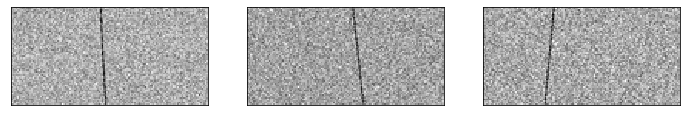

In [13]:
plt.figure(0, figsize=(12,12))
for i in range(1,4):
    plt.subplot(1, 3, i)
    img = np.squeeze(x_train[np.random.randint(0, x_train.shape[0])])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap='gray')

## Create Training and Validation Data Generators

In [17]:
#Data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(horizontal_flip=True)
datagen_train.fit(x_train)

datagen_val = ImageDataGenerator(horizontal_flip=True)
datagen_val.fit(x_val)

## Task 5: Creating the CNN Model

In [18]:
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint

In [20]:
# Initialising the CNN
model = Sequential()

# 1st Convolution
model.add(Conv2D(32, (5,5), padding = 'same', input_shape=(64, 128, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
#relu to add non linearity and in practice it is seen that our nn works better when non linearity is added
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(64, (5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
#relu to add non linearity and in practice it is seen that our nn works better when non linearity is added
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
# Flattening
model.add(Flatten())

# Fully connected layer
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(4, activation='softmax'))



## Learning Rate Scheduling and Compile the Model

In [23]:
initial_learning_rate = 0.005
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=5,
    decay_rate=0.96,
    staircase=True
)
optimizer = Adam(learning_rate=lr_schedule)

In [24]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 128, 32)       832       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 128, 32)       128       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 128, 32)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 64, 64)        51264     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 64, 64)       

## Training the Model

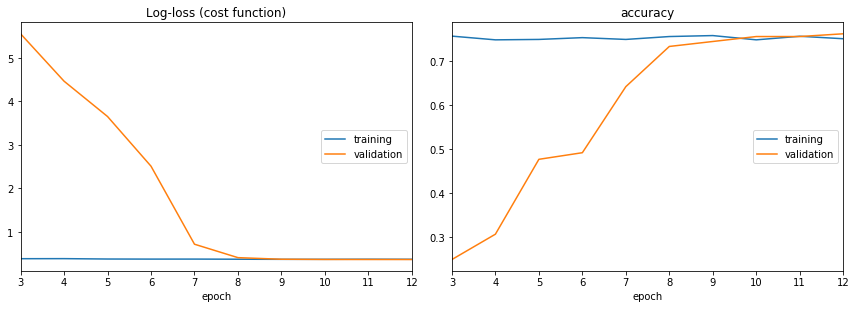

Log-loss (cost function):
training   (min:    0.370, max:    0.599, cur:    0.371)
validation (min:    0.366, max:    5.552, cur:    0.366)

accuracy:
training   (min:    0.695, max:    0.758, cur:    0.751)
validation (min:    0.250, max:    0.762, cur:    0.762)
100/100 [==============================] - 7s 74ms/step - loss: 0.3714 - accuracy: 0.7513 - val_loss: 0.3657 - val_accuracy: 0.7625


In [26]:
checkpoint = ModelCheckpoint('model_weight.h5', monitor = 'val_loss', save_weights_only=True, 
                             mode='min', verbose = 0)
callbacks = [PlotLossesCallback(), checkpoint]

batch_size = 32

history = model.fit(
    datagen_train.flow(x_train, y_train, batch_size=batch_size, shuffle=True),
    steps_per_epoch = len(x_train) //batch_size,
    validation_data = datagen_val.flow(x_val, y_val, batch_size=batch_size, shuffle=True),
    validation_steps = len(x_val) // batch_size,
    epochs = 12,
    callbacks=callbacks
)

## Model Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns



In [ ]:
labels = ["squiggle", "narrowband", "noise", "narrowbanddrd"]
